# Example of Pandas-TA technical indicators with multiple plot backends

The plotting backends will be matplotlib, plotly, and bokeh mostly. Matplotlib is flexible, but not dynamic, and the others are dynamic, but don"t have all the features that matplotlib has. The most problematic for technical analysis are related to the need to shade segments of indicator lines differently according to some criteria, or to shade areas between lines, shade them differently, or shading histogram bars differently. All of these present some issues, and we show below how to use Pandas-TA and some backends to achieve the functionality you would expect from some indicators.

In [17]:
import numpy as np
import pandas as pd
import pandas_ta as ta

import yfinance as yf
symbol = ["SPY", "XOM"][0]
tickerdata = yf.download(symbol, period="ytd", interval="1d")
tickerdata.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2023-01-03 to 2023-11-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       217 non-null    float64
 1   High       217 non-null    float64
 2   Low        217 non-null    float64
 3   Close      217 non-null    float64
 4   Adj Close  217 non-null    float64
 5   Volume     217 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 11.9 KB


## TMO: True Momentum Oscillator

This indicator computes the signum of the price difference of an asset for a duration of *tmo_length* and then smoothes it with a moving average with a window *calc_length*. This smoothed value is then smoothed again with another moving average with window *smooth_length* to generate the TMO **main signal**, and this in turn is smoothed again with another moving average with the same *smooth_length* window to generate the TMO"s **smooth signal**.
Some indicators normalize the result so that it lies within the $[-100,100]$ range, which allows for easy setting of overbought and oversold regions at 70 and -70 respectively, or 80 and -80.

The default values for the moving averages and the summation are $\text{TMO}_{length}=14, \ \text{Calc}_{length}=5, \ \text{Smooth}_{length}=3$ The occasional [exceptions](https://forexobroker.com/true-momentum-oscillator-indicator/) in [some platforms](https://www.tradingview.com/script/HibAeQPA-TMO-with-TTM-Squeeze/) might set $\text{Smooth}_{length}=6$ or $\text{TMO}_{length}=21$, but the majority uses the $14/5/3$ values and a default exponential moving average.
Computing an histogram is trivial from the provided fields in the dataframe.
Some other indicators go further, by computing the momentum of the TMO"s **main signal** and **smooth_signal**.

Both the normalization and the momentum computation are **not** done by default.

In [18]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

from pandas_ta.momentum import tmo

In [19]:
# True Momentum Oscillator calculation
tmo_length = 14
calc_length = 5
smooth_length = 3
compute_momentum = True
normalize_signal = False

data = tmo(
    tickerdata["Open"], tickerdata["Close"], 
    tmo_length=tmo_length, calc_length=calc_length, smooth_length=smooth_length, 
    mamode="ema", compute_momentum=compute_momentum, normalize_signal=normalize_signal)

data.dropna()
data = data.dropna().reset_index()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          182 non-null    datetime64[ns]
 1   TMO_14_5_3    182 non-null    float64       
 2   TMOs_14_5_3   182 non-null    float64       
 3   TMOM_14_5_3   182 non-null    float64       
 4   TMOMs_14_5_3  182 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.2 KB


### TMO: Matplotlib

We compute the unnormalized TMO and the optional momentums, with the default EMA moving average and default periods.
Similarly to this [TMO version](https://www.tradingview.com/script/VRwDppqd-True-Momentum-Oscillator/), the information provided in the dataframe suffices to shade the TMO main signal green if above the smoth signal, or red if below. The additional histogram can be computed trivially from the returned values of the TMO dataframe. This histogram reflects the difference between the TMO main signal and the TMO smooth signal, and is shaded green or red, if positive or negative.
Note that since we shade areas between a non traced TMO value and its smooth value, we need to add a custom legend and label. That"s the purpose of ```HandlerTuple```. See below.
Values are not normalized.

In [21]:
# to deal with shaded traces
from matplotlib.legend_handler import HandlerTuple
from scipy.interpolate import make_interp_spline

# interpolation density for trace spline interpolation
# if you want the linear data as is without interpolation, use interpolate=False
density = 500
interpolate=False

def compute_interp_data(x, y):
    xy_spline = make_interp_spline(x, y)
    x_ = np.linspace(x.min(), x.max(), density)
    y_ = xy_spline(x_)
    return (x_, y_)

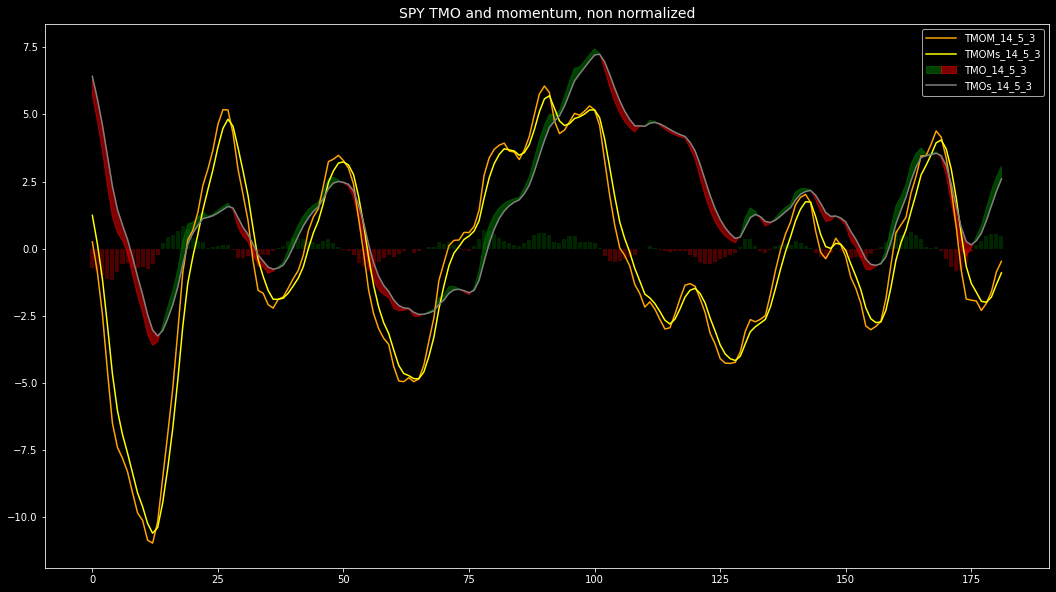

In [22]:
fig, ax = plt.subplots(figsize=(18, 10))

# Plot momentum lines, but the dataframe can contain any parameter names combination
# so access by index position as seen above in the data.info() 
tmo_main = data.iloc[:, 1]
tmo_smooth = data.iloc[:, 2]

if compute_momentum is True:
    tmo_main_mom = data.iloc[:, 3]
    tmo_smooth_mom = data.iloc[:, 4]
    if interpolate is False:
        ax.plot(data.index, tmo_main_mom, color="orange", label=data.columns[3])
        ax.plot(data.index, tmo_smooth_mom, color="yellow", label=data.columns[4])
    else:
        x, y = compute_interp_data(data.index, tmo_main_mom)
        ax.plot(x, y, color="orange", label=data.columns[3])
        x, y = compute_interp_data(data.index, tmo_smooth_mom)
        ax.plot(x, y, color="yellow", label=data.columns[4])       

# Main TMO line (for reference, we are shading only the areas betweem main and smooth signal)
# ax.plot(data.index, tmo_main, color="grey", alpha=0.7, linestyle=":", label=data.columns[1])

# Plot Smooth Signal
if interpolate is False:
    ax.plot(data.index, tmo_smooth, color="grey", label=data.columns[2])
else:
    x, y = compute_interp_data(data.index, tmo_smooth)
    ax.plot(x, y, color="grey", label=data.columns[2])

# Conditional fill between Main Signal and Smooth Signal
if interpolate is False:
    ax.fill_between(data.index, tmo_main, tmo_smooth, 
                    where=(tmo_main > tmo_smooth), interpolate=True, color="green", alpha=0.5,
                    label=data.columns[1])
    ax.fill_between(data.index, tmo_main, tmo_smooth, 
                    where=(tmo_main <= tmo_smooth), interpolate=True, color="red", alpha=0.5,
                    label=data.columns[1])
else:
    x1, y1 = compute_interp_data(data.index, tmo_main)
    x2, y2 = compute_interp_data(data.index, tmo_smooth)
    ax.fill_between(x1, y1, y2, 
                    where=(y1 > y2), interpolate=True, color="green", alpha=0.5,
                    label=data.columns[1])
    ax.fill_between(x1, y1, y2, 
                    where=(y1 <= y2), interpolate=True, color="red", alpha=0.5,
                    label=data.columns[1])   

# Adding histogram
if interpolate is False:
    colors = ["g" if main > smooth else "r" for main, smooth in zip(tmo_main, tmo_smooth)]
else:
    x1, y1 = compute_interp_data(data.index, tmo_main)
    x2, y2 = compute_interp_data(data.index, tmo_smooth)
    colors = ["g" if main > smooth else "r" for main, smooth in zip(y1, y2)]
    
ax.bar(data.index, tmo_main - tmo_smooth, color=colors, alpha=0.3)

# Get handles and labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(np.unique(labels))

# Combine the handlers using HandlerTuple
combined_handles = [tuple([h for h, l in zip(handles, labels) if l == label]) for label in unique_labels]

# Create the legend with combined handles and unique labels
ax.legend(handles=combined_handles, labels=unique_labels + [""], handlelength=3,
          handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

#plt.legend()
plt.title(f"{str(symbol)[0:]} TMO and momentum, non normalized", fontsize=14, color="white")
plt.show()

Next we check if the TMO indicator can be accessed directly from within the Pandas dataframe, besides as a regular indicator, and dump the information on the dataframe.

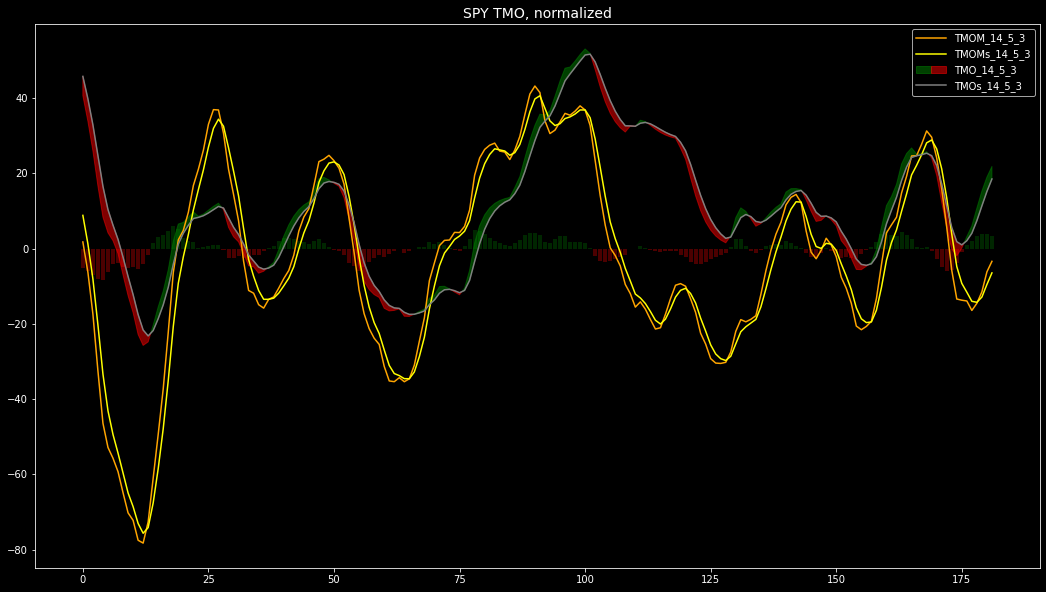

In [33]:
fig, ax = plt.subplots(figsize=(18, 10))

compute_momentum = True
normalize_signal = True

data = tmo(
    tickerdata["Open"], tickerdata["Close"], 
    tmo_length=tmo_length, calc_length=calc_length, smooth_length=smooth_length, 
    mamode="ema", compute_momentum=compute_momentum, normalize_signal=normalize_signal)

data.dropna()
data = data.dropna().reset_index()
tmo_main = data.iloc[:, 1]
tmo_smooth = data.iloc[:, 2]

if compute_momentum is True:
    tmo_main_mom = data.iloc[:, 3]
    tmo_smooth_mom = data.iloc[:, 4]
    if interpolate is False:
        ax.plot(data.index, tmo_main_mom, color="orange", label=data.columns[3])
        ax.plot(data.index, tmo_smooth_mom, color="yellow", label=data.columns[4])
    else:
        x, y = compute_interp_data(data.index, tmo_main_mom)
        ax.plot(x, y, color="orange", label=data.columns[3])
        x, y = compute_interp_data(data.index, tmo_smooth_mom)
        ax.plot(x, y, color="yellow", label=data.columns[4])       

# Main TMO line (for reference, we are shading only the areas betweem main and smooth signal)
# ax.plot(data.index, tmo_main, color="grey", alpha=0.7, linestyle=":", label=data.columns[1])

# Plot Smooth Signal
if interpolate is False:
    ax.plot(data.index, tmo_smooth, color="grey", label=data.columns[2])
else:
    x, y = compute_interp_data(data.index, tmo_smooth)
    ax.plot(x, y, color="grey", label=data.columns[2])

# Conditional fill between Main Signal and Smooth Signal
if interpolate is False:
    ax.fill_between(data.index, tmo_main, tmo_smooth, 
                    where=(tmo_main > tmo_smooth), interpolate=True, color="green", alpha=0.5,
                    label=data.columns[1])
    ax.fill_between(data.index, tmo_main, tmo_smooth, 
                    where=(tmo_main <= tmo_smooth), interpolate=True, color="red", alpha=0.5,
                    label=data.columns[1])
else:
    x1, y1 = compute_interp_data(data.index, tmo_main)
    x2, y2 = compute_interp_data(data.index, tmo_smooth)
    ax.fill_between(x1, y1, y2, 
                    where=(y1 > y2), interpolate=True, color="green", alpha=0.5,
                    label=data.columns[1])
    ax.fill_between(x1, y1, y2, 
                    where=(y1 <= y2), interpolate=True, color="red", alpha=0.5,
                    label=data.columns[1])   

# Adding histogram
if interpolate is False:
    colors = ["g" if main > smooth else "r" for main, smooth in zip(tmo_main, tmo_smooth)]
else:
    x1, y1 = compute_interp_data(data.index, tmo_main)
    x2, y2 = compute_interp_data(data.index, tmo_smooth)
    colors = ["g" if main > smooth else "r" for main, smooth in zip(y1, y2)]
    
ax.bar(data.index, tmo_main - tmo_smooth, color=colors, alpha=0.3)

# Get handles and labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(np.unique(labels))

# Combine the handlers using HandlerTuple
combined_handles = [tuple([h for h, l in zip(handles, labels) if l == label]) for label in unique_labels]

# Create the legend with combined handles and unique labels
ax.legend(handles=combined_handles, labels=unique_labels + [""], handlelength=3,
          handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

plt.title(f"{str(symbol)[0:]} TMO, normalized", fontsize=14, color="white")
#plt.legend()
plt.show()

In [24]:
tickerdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2023-01-03 to 2023-11-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       217 non-null    float64
 1   High       217 non-null    float64
 2   Low        217 non-null    float64
 3   Close      217 non-null    float64
 4   Adj Close  217 non-null    float64
 5   Volume     217 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 11.9 KB


In [25]:
# direct invocation
tmo(tickerdata["Open"], tickerdata["Close"])

,TMO_14_5_3,TMOs_14_5_3,TMOM_14_5_3,TMOMs_14_5_3
Date,,,,
2023-01-03,NaN,NaN,0.0,0.0
2023-01-04,NaN,NaN,0.0,0.0
2023-01-05,NaN,NaN,0.0,0.0
2023-01-06,NaN,NaN,0.0,0.0
2023-01-09,NaN,NaN,0.0,0.0
...,...,...,...,...
2023-11-06,0.850934,0.573673,0.0,0.0
2023-11-07,1.509272,1.041472,0.0,0.0
2023-11-08,2.143839,1.592656,0.0,0.0


In [26]:
# TMO called from the dataframe"s Pandas-TA extension
df = tickerdata.copy()

df.ta.tmo(append=True)

,TMO_14_5_3,TMOs_14_5_3,TMOM_14_5_3,TMOMs_14_5_3
Date,,,,
2023-01-03,NaN,NaN,0.0,0.0
2023-01-04,NaN,NaN,0.0,0.0
2023-01-05,NaN,NaN,0.0,0.0
2023-01-06,NaN,NaN,0.0,0.0
2023-01-09,NaN,NaN,0.0,0.0
...,...,...,...,...
2023-11-06,0.850934,0.573673,0.0,0.0
2023-11-07,1.509272,1.041472,0.0,0.0
2023-11-08,2.143839,1.592656,0.0,0.0


### TMO: Plotly

With Plotly, to the best of my knowledge, we can't shade the areas between the lines. Not without artifacts at least. But we can shade the TMO **main signal** line red or green, according to it being below or above the TMO **smooth signal** line. Sadly this seems to result in a plethora of traces, which get their legend entries, rather than a single trace with a legend we could add and shade separately as we did with matplotlib.
Overbought and oversold areas are added, and for that we pass ```normalize_signal=True``` to the TMO indicator.

In [27]:
from datetime import datetime

import plotly.graph_objects as go

compute_momentum=True
normalize_signal=True

data = tmo(
    tickerdata["Open"], tickerdata["Close"], 
    tmo_length=tmo_length, calc_length=calc_length, smooth_length=smooth_length, 
    mamode="ema", compute_momentum=compute_momentum, normalize_signal=True)

data.dropna()
data = data.dropna().reset_index()

tmo_main = data.iloc[:, 1]
tmo_smooth = data.iloc[:, 2]

if compute_momentum is True:
    tmo_main_mom = data.iloc[:, 3]
    tmo_smooth_mom = data.iloc[:, 4]

In [28]:
fig = go.Figure()

# somehow we have extra spacing for non-trading days, fix this with datetime and tick spacing
tick_spacing = len(data.index) // 10
tickvals = data.index[::tick_spacing]
ticktext = [datetime.strftime(pd.Timestamp(date), "%d/%m/%y") for date in tickvals]

fig.add_trace(go.Scatter(x=data.index, y=tmo_main_mom, mode="lines", name=data.columns[3], line=dict(color="orange", width=1.0)))
fig.add_trace(go.Scatter(x=data.index, y=tmo_smooth_mom, mode="lines", name=data.columns[4], line=dict(color="yellow", width=1.0)))

#fig.add_trace(go.Scatter(x=data.index, y=tmo_main, mode="lines", name=data.columns[1], line=dict(color="red")))
fig.add_trace(go.Scatter(x=data.index, y=tmo_smooth, mode="lines", name=data.columns[2], line=dict(color="grey", width=1.0, dash="dot")))

# The default wasn't very readable, so adjust the scaling of the histogram bars (height)
# and the opacity as needed.
scaling_factor = 2.0
bar_opacity = 0.3

# Add the histogram, and scale by a completely arbitrary user factor
colors = ["green" if main > smooth else "red" for main, smooth in zip(tmo_main, tmo_smooth)]
scaled_histogram_values = (tmo_main - tmo_smooth) * scaling_factor

fig.add_trace(go.Bar(x=data.index, y=scaled_histogram_values, marker=dict(color=colors, opacity=bar_opacity), name="Main-Smooth Histogram"))

# Create MainSignal line as segments to allow multiple colors
last_switch_point = 0 
current_color = colors[0]

# Create a custom legend for TMO main signal with legendgroup, to keep the
# red and green legend associated with the main signal. This is the best we can do for now.
for i in range(1, len(colors)):
    if colors[i] != current_color:
        fig.add_trace(go.Scatter(x=data.index[last_switch_point:i+1], y=data[data.columns[1]].iloc[last_switch_point:i+1],
                                 mode="lines", name=data.columns[1], showlegend=False, line=dict(color=current_color, width=2.0),
                                 legendgroup="TMO Main Signal"))
        last_switch_point = i
        current_color = colors[i]

# and add the last segment
fig.add_trace(go.Scatter(x=data.index[last_switch_point:], y=data[data.columns[1]].iloc[last_switch_point:],
                         mode="lines", name=data.columns[1], showlegend=False, line=dict(color=current_color, width=2.0),
                         legendgroup="TMO Main Signal"))

fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", name="TMO Main Signal",
                         legendgroup="TMO Main Signal", line=dict(color="red", width=2.0)))
fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines", name="TMO Main Signal",
                         legendgroup="TMO Main Signal", line=dict(color="green", width=2.0)))

# Add overbought and oversold lines at y=70 and y=-70 respectively
# Add horizontal dashed lines at y=70 and y=-70
fig.add_shape(
    go.layout.Shape(type="line", x0=data.index.min(), x1=data.index.max(), y0=70, y1=70, line=dict(color="red", dash="dash", width=1.0), opacity=0.3,
    ))
fig.add_shape(
    go.layout.Shape(type="line", x0=data.index.min(), x1=data.index.max(), y0=-70, y1=-70, line=dict(color="green", dash="dash", width=1.0), opacity=0.3,
    ))
fig.add_shape(
    go.layout.Shape(type="rect", x0=data.index.min(), x1=data.index.max(), y0=70, y1=100, fillcolor="red", opacity=0.05, layer="below",
    ))
fig.add_shape(
    go.layout.Shape(type="rect", x0=data.index.min(), x1=data.index.max(), y0=-100, y1=-70, fillcolor="green", opacity=0.05, layer="below",
    ))

fig.update_layout(
    title=f"{str(symbol)[0:]} stock with TMO indicator",
    xaxis=dict(
        title="Date",
        tickvals=tickvals,
        ticktext=ticktext,
        type="category"
    ),
    yaxis=dict(title="Value"),
    yaxis2=dict(title="Difference", overlaying="y", side="right"),
    height=600,
    template="plotly_dark"
)

fig.show()

### TMO: Bokeh

As yet another alternative bokeh is provided. It suffers from the same fallbacks as plotly in regard to dynamic shading, so we split segments into N traces and shade them accordingly. A custom legend is needed. 
If you want to create advanced plots with conditional traces, you either use matplotlib, or use something more dynamic but limited.

In [29]:
from bokeh.io import output_notebook, curdoc
from bokeh.models import ColumnDataSource, LegendItem
from bokeh.plotting import figure, show

curdoc().theme = "dark_minimal"

In [30]:
p = figure(title=f"{str(symbol)[0:]} TMO and momentum, normalized", x_axis_type="datetime", width=1200, height=500)

green_data = data[tmo_main > tmo_smooth]
red_data = data[tmo_main <= tmo_smooth]

# We need to use the same approach as plotly, since bokeh cannot shade the line trace
# dynamically. Instead, break the line in N segments.
xs, ys, colors = [], [], []

for i in range(1, len(tmo_main)):
    xs.append([tmo_main.index[i-1], tmo_main.index[i]])
    ys.append([tmo_main.iloc[i-1], tmo_main.iloc[i]])
    color = "green" if tmo_main.iloc[i] > tmo_smooth.iloc[i] else "red"
    colors.append(color)

# so shade the N individual segments
for i in range(len(xs)):
    p.line(xs[i], ys[i], line_width=2, line_color=colors[i])

#p.line(data.index, tmo_main, color="red", legend_label=data.columns[1])
p.line(data.index, tmo_smooth, color="grey", legend_label=data.columns[2])

if compute_momentum:
    p.line(data.index, tmo_main_mom, color="orange", legend_label=data.columns[3])
    p.line(data.index, tmo_smooth_mom, color="yellow", legend_label=data.columns[4])

# Add the histogram, but ommit the label
hist_source = ColumnDataSource(data=dict(
    x=data.index,
    top=(tmo_main - tmo_smooth) * scaling_factor,
    colors=np.where(tmo_main > tmo_smooth, "green", "red"),
))
p.vbar(x='x', top='top', source=hist_source, width=1, fill_color='colors', fill_alpha=0.3, line_color=None) #, legend_label="Main-Smooth Histogram")

# We can't place a legend patch side by side to the best of my knowledge. We can just not add the legend entries
# to the N segments, and create 2 invisible segments for red and green, adding the TMO main signal legend entry.
# It'll have to suffice for the time being.
green_legend_line = p.line(x=[0, 0], y=[0, 0], color="green", line_width=2, visible=False)
red_legend_line = p.line(x=[0, 0], y=[0, 0], color="red", line_width=2, visible=False)

custom_legend_item_green = LegendItem(label=data.columns[1], renderers=[green_legend_line])
custom_legend_item_red = LegendItem(label=data.columns[1], renderers=[red_legend_line])

p.legend[0].items.extend([custom_legend_item_green, custom_legend_item_red])
output_notebook()
show(p)

Loading BokehJS ...

### TMO: combining with other indicators

Other indicators combine TMO with, for example, John Carter's [TTM Squeeze](https://school.stockcharts.com/doku.php?id=technical_indicators:ttm_squeeze) indicator, as seen [here](https://www.tradingview.com/script/HibAeQPA-TMO-with-TTM-Squeeze/)
The ability to control the traces and legends dynamically, zoom-in/out, pan, makes the other plotting alternatives to matplotlib, solid propositions.

In [31]:
for i in range(1, 5, 1):
    print(data.columns[i])

TMO_14_5_3
TMOs_14_5_3
TMOM_14_5_3
TMOMs_14_5_3


In [32]:
data = tmo(
    tickerdata["Open"], tickerdata["Close"], 
    tmo_length=tmo_length, calc_length=calc_length, smooth_length=smooth_length, 
    mamode="ema", compute_momentum=compute_momentum, normalize_signal=normalize_signal)

print(data.name)

TMO_14_5_3
